<a href="https://colab.research.google.com/github/patel-zeel/Nonstat-exps/blob/main/GP_Extra_whitekernel_added.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import clear_output
!git clone https://github.com/jmetzen/gp_extras.git
!cd gp_extras;python setup.py install;
!pip -qq install pods
clear_output()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern, WhiteKernel
from gp_extras.kernels import ManifoldKernel, LocalLengthScalesKernel, HeteroscedasticKernel
from sklearn.preprocessing import StandardScaler

# Local lengthscale kernel

Tries to learn lengthscale locally for few points without affecting overall fit

## Step function

shape of train_X= (20, 1) shape of train_y= (20, 1)


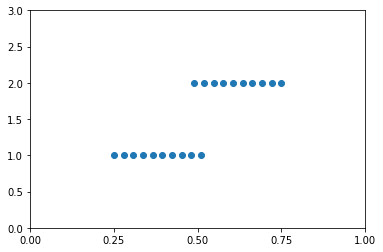

In [3]:
train_X = np.concatenate([np.linspace(0.25,0.51,10), np.linspace(0.49,0.75,10)]).reshape(-1,1)
train_y = np.concatenate([np.ones((10, 1)), np.ones((10, 1))*2])
test_X = np.linspace(0,1,120).reshape(-1,1)
print("shape of train_X=",train_X.shape, "shape of train_y=",train_y.shape)
plt.scatter(train_X, train_y)
plt.ylim(0,3);plt.xticks([0,0.25,0.5,0.75,1]);

## Defining stationary and non-stationary GPs (gp, GPygp and nonstat_gp)

In [4]:
# Stationary kernel
def sklearn_gp(K):
  kernel = C() * K + WhiteKernel()
  return GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=0)

# Non stationary kernel
from scipy.optimize import differential_evolution
def LLS_gp(n_samples):
  scaler = StandardScaler()
  train_XX = scaler.fit_transform(train_X)
  def de_optimizer(obj_func, initial_theta, bounds):
      res = differential_evolution(lambda x: obj_func(x, eval_gradient=False),
                                  bounds, maxiter=20, disp=False, polish=False)
      return res.x, obj_func(res.x, eval_gradient=False)
  nonstat_kernel = (C() * LocalLengthScalesKernel.construct(train_XX, l_samples=n_samples)) + WhiteKernel()
  return GaussianProcessRegressor(kernel=nonstat_kernel, alpha=1e-5,
                                n_restarts_optimizer=10, random_state=0, optimizer=de_optimizer)

In [6]:
gp = sklearn_gp(RBF())
nonstat_gp = lambda n: LLS_gp(n)
print("Stationary kernel=\n", gp.kernel,sep='',end='\n\n')
print("LLS kernel=\n", nonstat_gp(1).kernel,sep='')

Stationary kernel=
1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1)

LLS kernel=
1**2 * LocalLengthScalesKernel(theta_gp=[0.1], theta_l=[0.1], length_scales=[1.]) + WhiteKernel(noise_level=1)


## Testing on step function

Stationary RBF 1.32**2 * RBF(length_scale=1.74) + WhiteKernel(noise_level=0.0711)
LLS RBF, n_samples= 1 2.18**2 * LocalLengthScalesKernel(theta_gp=[0.02562458], theta_l=[0.14246165], length_scales=[0.10125547]) + WhiteKernel(noise_level=1.02e-05)
LLS RBF, n_samples= 2 1.64**2 * LocalLengthScalesKernel(theta_gp=[0.00102153], theta_l=[0.86682583], length_scales=[1.42988436 0.6231074 ]) + WhiteKernel(noise_level=0.0578)
LLS RBF, n_samples= 3 1.24**2 * LocalLengthScalesKernel(theta_gp=[0.01518057], theta_l=[0.9504597], length_scales=[3.12758084 2.01482542 9.44017007]) + WhiteKernel(noise_level=0.0525)
LLS RBF, n_samples= 4 1.06**2 * LocalLengthScalesKernel(theta_gp=[0.00199278], theta_l=[0.76520932], length_scales=[0.69818243 1.13948071 2.17530629 2.19866118]) + WhiteKernel(noise_level=0.0654)
LLS RBF, n_samples= 5 2.74**2 * LocalLengthScalesKernel(theta_gp=[0.03436152], theta_l=[0.12205139], length_scales=[0.78757669 0.4541546  1.38853419 0.12204379 0.88380161]) + WhiteKernel(noise_level=

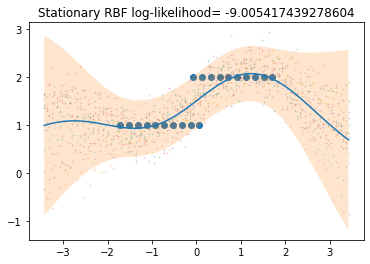

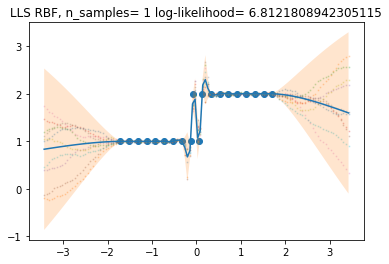

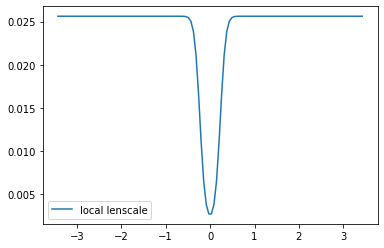

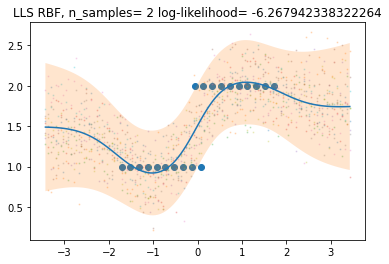

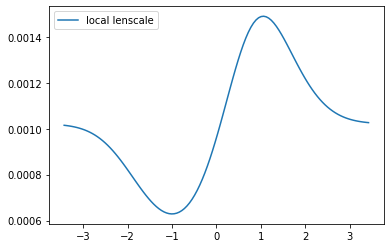

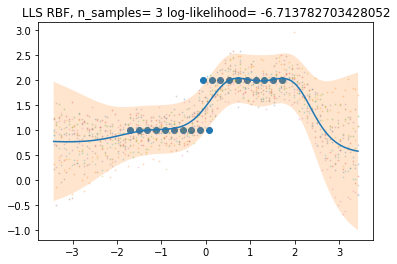

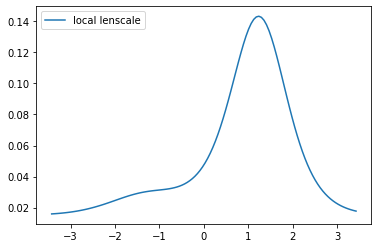

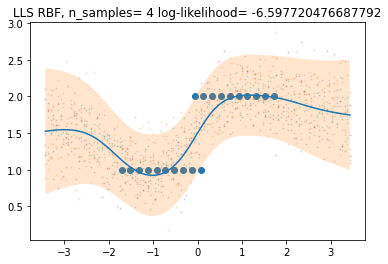

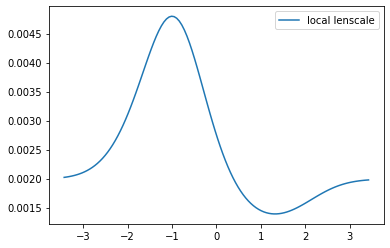

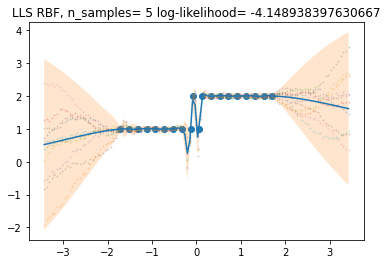

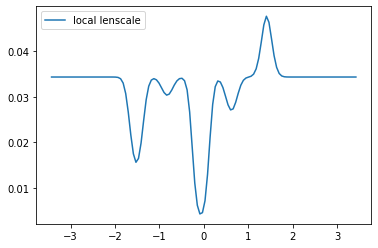

In [7]:
def fit_predict_plot(reg, name): # _XX refers to scaled variable
  plt.figure()
  scaler = StandardScaler()
  train_XX = scaler.fit_transform(train_X)
  test_XX = scaler.transform(test_X)
  reg.fit(train_XX, train_y)
  pred_y, cov_y = reg.predict(test_XX, return_cov=True)
  std_y = cov_y.diagonal()**0.5
  plt.scatter(train_XX, train_y)
  post_samples = reg.sample_y(test_XX, n_samples=10).squeeze().T
  for i in range(10):
    plt.scatter(test_XX.reshape(-1), post_samples[i], s=1, alpha=0.2)
  plt.plot(test_XX, pred_y)
  plt.fill_between(test_XX.reshape(-1), pred_y.reshape(-1)-2*std_y, pred_y.reshape(-1)+2*std_y, alpha=0.2)
  plt.title(name+' log-likelihood= '+str(reg.log_marginal_likelihood_value_))
  if name.startswith("LLS"):
    plt.figure()
    plt.plot(test_XX.reshape(-1), reg.kernel_.k1.k2.theta_gp
             * 10**reg.kernel_.k1.k2.gp_l.predict(test_XX.reshape(-1)[:, np.newaxis]), label='local lenscale')
    plt.legend()
  print(name, reg.kernel_)
  return reg

# Stationary
_ = fit_predict_plot(gp, 'Stationary RBF')

# Non-Stationary n_samples
for n_samples in range(1,6):
  fit_predict_plot(nonstat_gp(n_samples), 'LLS RBF, n_samples= '+str(n_samples))

## Olympic marathon data

Acquiring resource: olympic_marathon_men

Details of data: 
Olympic mens' marathon gold medal winning times from 1896 to 2012. Time given in pace (minutes per kilometer). Data is originally downloaded and collated from Wikipedia, we are not responsible for errors in the data

After downloading the data will take up 584 bytes of space.

Data will be stored in /root/ods_data_cache/olympic_marathon_men.

Do you wish to proceed with the download? [yes/no]
yes
[==============================]   0.001/0.001MB


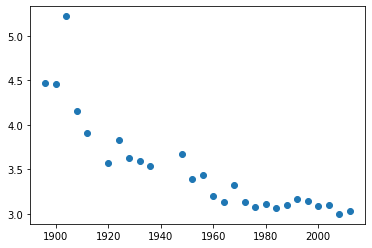

In [8]:
import pods
data = pods.datasets.olympic_marathon_men()
clear_output()
train_X = data['X']
test_X = np.linspace(data['X'].min()-10, data['X'].max()+10, 120).reshape(-1,1)
train_y = data['Y']
plt.scatter(train_X, train_y);

scaler = StandardScaler()
train_XX = scaler.fit_transform(train_X)
nonstat_kernel = lambda n: (C()*LocalLengthScalesKernel.construct(train_XX, l_samples=n)) + WhiteKernel()
def de_optimizer(obj_func, initial_theta, bounds):
      res = differential_evolution(lambda x: obj_func(x, eval_gradient=False),
                                  bounds, maxiter=20, disp=False, polish=False)
      return res.x, obj_func(res.x, eval_gradient=False)
nonstat_gp = lambda n: GaussianProcessRegressor(kernel=nonstat_kernel(n), alpha=1e-5,
                              n_restarts_optimizer=10, random_state=0, optimizer=de_optimizer)

## Testing

Stationary RBF 5.04**2 * RBF(length_scale=4.28) + WhiteKernel(noise_level=0.0485)
LLS RBF, n_samples= 1 3.99**2 * LocalLengthScalesKernel(theta_gp=[0.05830228], theta_l=[3.49903301], length_scales=[7.56946664]) + WhiteKernel(noise_level=0.0464)
LLS RBF, n_samples= 2 2.39**2 * LocalLengthScalesKernel(theta_gp=[0.52143868], theta_l=[2.06492905], length_scales=[0.8318492  7.63010712]) + WhiteKernel(noise_level=0.00507)
LLS RBF, n_samples= 3 2.42**2 * LocalLengthScalesKernel(theta_gp=[0.01313519], theta_l=[4.72677212], length_scales=[0.14504477 2.65698718 1.58400931]) + WhiteKernel(noise_level=0.00638)
LLS RBF, n_samples= 4 2.85**2 * LocalLengthScalesKernel(theta_gp=[0.01403794], theta_l=[0.05802057], length_scales=[0.96257774 1.06691666 0.65258847 0.66300223]) + WhiteKernel(noise_level=0.00615)
LLS RBF, n_samples= 5 4.19**2 * LocalLengthScalesKernel(theta_gp=[0.00715768], theta_l=[0.01334454], length_scales=[1.49004276 1.02312762 1.00723709 0.4146478  0.88299487]) + WhiteKernel(noise_leve

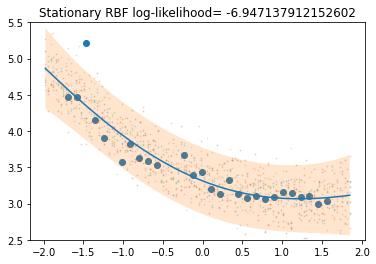

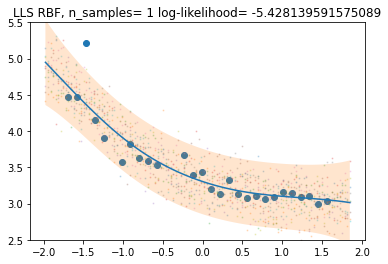

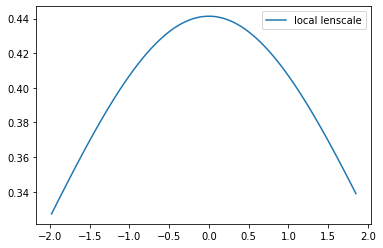

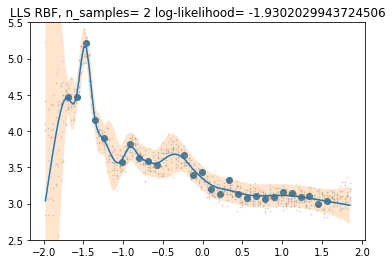

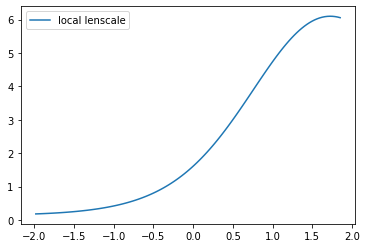

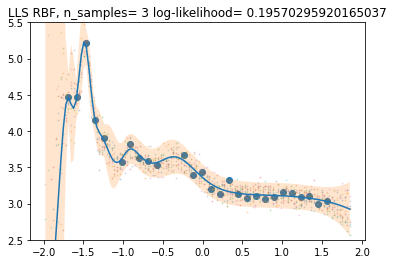

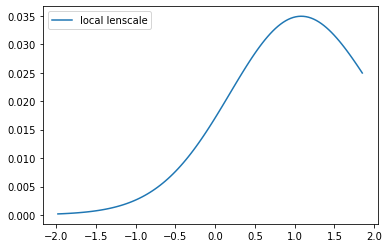

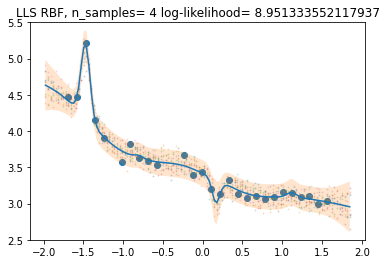

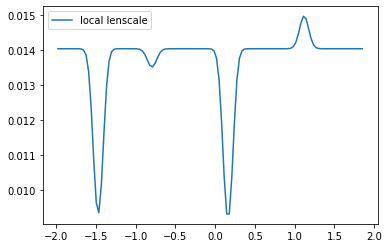

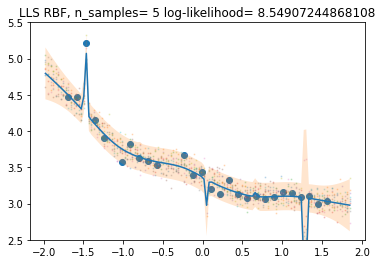

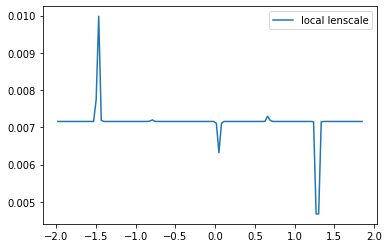

In [9]:
def fit_predict_plot(reg, name): # _XX refers to scaled variable
  plt.figure()
  scaler = StandardScaler()
  train_XX = scaler.fit_transform(train_X)
  test_XX = scaler.transform(test_X)
  reg.fit(train_XX, train_y)
  pred_y, cov_y = reg.predict(test_XX, return_cov=True)
  std_y = cov_y.diagonal()**0.5
  plt.scatter(train_XX, train_y)
  post_samples = reg.sample_y(test_XX, n_samples=10).squeeze().T
  for i in range(10):
    plt.scatter(test_XX.reshape(-1), post_samples[i], s=1, alpha=0.2)
  plt.plot(test_XX, pred_y)
  plt.fill_between(test_XX.reshape(-1), pred_y.reshape(-1)-2*std_y, pred_y.reshape(-1)+2*std_y, alpha=0.2)
  plt.ylim(2.5,5.5)
  plt.title(name+' log-likelihood= '+str(reg.log_marginal_likelihood_value_))
  if name.startswith("LLS"):
    plt.figure()
    plt.plot(test_XX.reshape(-1), reg.kernel_.k1.k2.theta_gp
             * 10**reg.kernel_.k1.k2.gp_l.predict(test_XX.reshape(-1)[:, np.newaxis]), label='local lenscale')
    plt.legend()
  print(name, reg.kernel_)
  return reg

# Stationary
_ = fit_predict_plot(gp, 'Stationary RBF')

# Non-Stationary n_samples
for n_samples in range(1,6):
  fit_predict_plot(nonstat_gp(n_samples), 'LLS RBF, n_samples= '+str(n_samples))

# Manifold kernel (work under progress)

Works similar to the neural network kernel. We can map individual features to multiple dimentions via seperate neural net architectures.

## Defining Stationary and Non-stationary GP (gp and nonstat_gp)

In [ ]:
# sklearn
kernel = C() * RBF()
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=0)

# GPy
class GPyGPR:
  def __init__(self, input_dim, kern):
    if kern=='rbf':
      self.GPykernel = GPyRBF(input_dim=input_dim, active_dims=list(range(input_dim)), ARD=False)
    if kern=='m32':
      self.GPykernel = GPyMatern(input_dim=input_dim, active_dims=list(range(input_dim)), ARD=False)
    self.kernel = self.GPykernel
  def fit(self, X, y):
    self.GP = GPRegression(X, y, self.GPykernel, noise_var=10**-10)
    self.GP.optimize_restarts(10, verbose=0)
    self.kernel_ = self.GP.kern
  
  def predict(self, X, return_cov):
    y, var = self.GP.predict(X, full_cov=True)
    return y, var

GPygp = GPyGPR(1, 'rbf')

# Non stationary kernel
nonstat_kernel = C()\
                *ManifoldKernel.construct(base_kernel=RBF(), architecture=((1, 2),),
                               transfer_fct="relu", max_nn_weight=1)
# architecture is neural net architecture (input_dim, hidden1_dim, hidden2_dim, ..., output_dim)
nonstat_gp = GaussianProcessRegressor(kernel=nonstat_kernel, alpha=1e-5,
                              n_restarts_optimizer=10, random_state=0)

print("sklearn kernel=\n", kernel,sep='',end='\n\n')
print("GPy kernel=\n", GPygp.GPykernel,sep='',end='\n\n')
print("Manifold kernel=\n", nonstat_kernel,sep='')

sklearn kernel=
1**2 * RBF(length_scale=1)

GPy kernel=
  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    1.0  |      +ve      |        

Manifold kernel=
1**2 * ManifoldKernel(0.957, 0.642, -0.948, 0.987, 0)


## Testing on step function

RBF 1.55**2 * RBF(length_scale=0.0975)
RBF GPy   rbf.         |               value  |  constraints  |  priors
  variance     |  1.7303604955328948  |      +ve      |        
  lengthscale  |  1.7354045254195403  |      +ve      |        
Manifold RBF 1.76**2 * ManifoldKernel(0.988, 0.106, 0.323, 0.0128, -2.36)


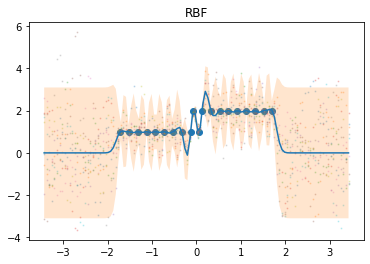

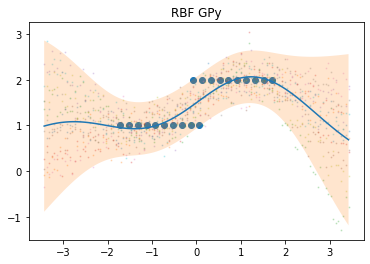

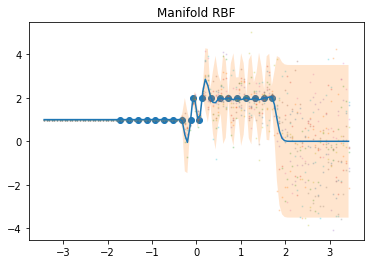

In [ ]:
def fit_predict_plot(reg, name): # _XX refers to scaled variable
  plt.figure()
  scaler = StandardScaler()
  train_XX = scaler.fit_transform(train_X)
  test_XX = scaler.transform(test_X)
  reg.fit(train_XX, train_y)
  pred_y, cov_y = reg.predict(test_XX, return_cov=True)
  std_y = cov_y.diagonal()**0.5
  plt.scatter(train_XX, train_y)
  post_samples = np.random.multivariate_normal(pred_y.reshape(-1), cov_y, 10)
  for i in range(10):
    plt.scatter(test_XX.reshape(-1), post_samples[i], s=1, alpha=0.2)
  plt.plot(test_XX, pred_y)
  plt.fill_between(test_XX.reshape(-1), pred_y.reshape(-1)-2*std_y, pred_y.reshape(-1)+2*std_y, alpha=0.2)
  plt.title(name)
  print(name, reg.kernel_)

# Stationary
fit_predict_plot(gp, 'RBF')
# Stationary
fit_predict_plot(GPygp, 'RBF GPy')
# Non-Stationary
fit_predict_plot(nonstat_gp, 'Manifold RBF')

# Appendix

In [ ]:
#!pip -qq install pods
#!pip -qq install GPy
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
import pods
data = pods.datasets.olympic_marathon_men()
X = data['X']
y = data['Y']
# scikit-learn
model = GaussianProcessRegressor(C()*RBF(), n_restarts_optimizer=20, random_state=0)
model.fit(X, y)
print(model.kernel_)
model.sample_y(X, n_samples=10, random_state=0).shape

# # GPy
# from GPy.models import GPRegression
# from GPy.kern import RBF as GPyRBF
# model = GPRegression(X, y, GPyRBF(1))
# model.optimize_restarts(20, verbose=0)
# print(model.kern)

2.89**2 * RBF(length_scale=6.15)


(27, 1, 10)